In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Tuple, Optional
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
tqdm.pandas()
sns.set_context("paper")

In [ ]:
path_to_results_dir: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/ppl/val'
variant: str = 'dataset=FEMRDataset-stride=32-n_patients=1000-is_config=False'

path_to_results: str = os.path.join(path_to_results_dir, variant)

# Stability of Val/PPL Readout

How stable is our estimate of val/ppl v. number of patients?

Experiment: Calculate val/ppl for same model across 1k, 5k, 10k, 20k val patients and measure deviation.

NOTE: It takes ~2.5 hrs for 10k patients.

In [15]:
path_to_base_results: str = '/share/pi/nigam/mwornow/hf_ehr/cache/runs/archive/gpt-base-1024--clmbr/ppl/val/'
path_to_1k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=1000-is_config=False')
path_to_5k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=5000-is_config=False')
path_to_10k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=10000-is_config=False')
path_to_50k = os.path.join(path_to_base_results, 'dataset=FEMRDataset-stride=32-n_patients=50000-is_config=False')
file_name: str = 'train-tokens-total_nonPAD-true_val=2400000000-ckpt_val=2400000000-persist'

def parse_json(path: str) -> Dict:
    data = json.load(open(path + '.json', 'r'))
    ppl_per_token = data['results']['ppl_per_token']
    n_tokens = data['results']['n_tokens']
    return {'ppl_per_token': ppl_per_token, 'n_tokens': n_tokens}

df = pd.DataFrame({
    '1k': parse_json(os.path.join(path_to_1k, file_name)),
    '5k': parse_json(os.path.join(path_to_5k, file_name)),
    '10k': parse_json(os.path.join(path_to_10k, file_name))
}).T
df

,ppl_per_token,n_tokens
1k,9.066060,659969.0
5k,8.713906,3460702.0
10k,8.533232,7407861.0


# What does the val/ppl distribution look like?

Let's do some EDA.

In [75]:
df = pd.read_parquet(os.path.join(path_to_10k, file_name) + '.parquet')

In [76]:
def print_percentiles(values: pd.Series):
    percentiles = [  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 95, 99, 100]
    percentile_values = np.percentile(values, percentiles)
    df_percentiles = pd.DataFrame({
        'percentile': percentiles,
        'ppl': percentile_values
    })
    with pd.option_context('display.float_format', lambda x: '%.3f' % x):
        print("==== Percentiles ====")
        print(df_percentiles)

with pd.option_context('display.float_format', lambda x: '%.3f' % x):
    print("==== Overview ====")
    print(df['label_ppl'].describe())
    print_percentiles(df['label_ppl'])

==== Overview ====


count       7407861.000
mean          12264.440
std         8205482.023
min               1.000
25%               1.680
50%               4.760
75%              20.161
max     21648180707.099
Name: label_ppl, dtype: float64
==== Percentiles ====
    percentile             ppl
0            0           1.000
1           10           1.058
2           20           1.384
3           30           2.037
4           40           3.102
5           50           4.760
6           60           7.510
7           70          13.610
8           80          33.210
9           90         164.178
10          95         765.303
11          99       16672.829
12         100 21648180707.099


In [77]:
# Who is the major outlier?
df.iloc[df['label_ppl'].argmax()]

pid                                          29944812
n_events                                         5017
n_tokens                                         4109
token_idx                                          85
label                                           11515
label_log_prob                             -23.798187
argmax_label                                     1653
argmax_log_prob                             -0.000396
label_ppl                          21648180707.099365
label_as_token                       SNOMED/282741006
label_as_token_desc            Post-herpetic neuritis
argmax_ppl                                   1.000396
argmax_as_token                      SNOMED/408277005
argmax_as_token_desc    APTT inhibitor screening test
Name: 2924516, dtype: object

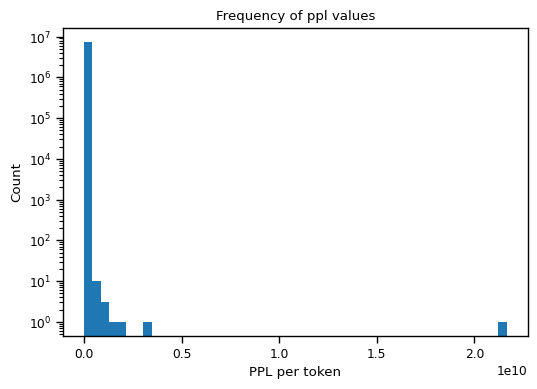

In [78]:
plt.figure(figsize=(6, 4))
plt.hist(df['label_ppl'], bins=50, log=True)  # Apply log scale to y-axis (or x-axis if needed)
plt.xlabel('PPL per token')
plt.ylabel('Count')
plt.title('Frequency of ppl values')
plt.show()

## PPL v. token position

Given a token's location in a sequence, what is the median ppl we can expect? (NOTE: Use median instead of mean due to huge right skew outliers)

In [79]:
print_percentiles(df[df['token_idx'] == 0]['label_ppl'])
print_percentiles(df[df['token_idx'] == 1]['label_ppl'])
print_percentiles(df[df['token_idx'] == 2]['label_ppl'])

==== Percentiles ====
    percentile          ppl
0            0        2.369
1           10        2.369
2           20        2.369
3           30        2.971
4           40        2.971
5           50        2.971
6           60        7.038
7           70        7.038
8           80        7.038
9           90       17.102
10          95       17.102
11          99      306.649
12         100 19116160.155
==== Percentiles ====
    percentile          ppl
0            0        1.000
1           10        1.002
2           20        1.004
3           30        1.004
4           40        1.004
5           50        4.040
6           60        5.552
7           70        6.506
8           80       10.815
9           90       64.906
10          95     1099.603
11          99    63749.762
12         100 46621117.571
==== Percentiles ====
    percentile          ppl
0            0        1.000
1           10        1.187
2           20        1.207
3           30        1.233
4         

In [82]:
# Count token position frequencies
df_token_position_counts = df['token_idx'].value_counts().sort_index().reset_index()

# Filter out any token positions with < min_count occurrences
min_count: int = 100
keep_token_idxs: List[int] = df_token_position_counts[df_token_position_counts['count'] >= min_count]['token_idx'].tolist()
print(f"Keeping {len(keep_token_idxs)} token positions (i.e. all token positions with >= {min_count} data points)")

Keeping 10975 token positions (i.e. all token positions with >= 100 data points)


Processing token positions:   0%|          | 5/10975 [00:00<03:43, 49.17it/s]

Processing token positions: 100%|██████████| 10975/10975 [01:48<00:00, 101.22it/s]


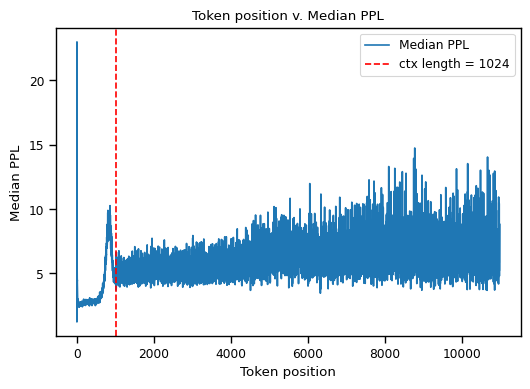

In [85]:
# Plot token position v. avg. val/ppl
is_plot_ci: bool = False
df_pos_to_ppl = []
for token_idx in tqdm(keep_token_idxs, desc='Processing token positions'):
    # 1. Calculate median PPL for this token positions
    df_token_idx = df[df['token_idx'] == token_idx]
    median = df_token_idx['label_ppl'].median()
    if not is_plot_ci:
        df_pos_to_ppl.append({
            'token_idx': token_idx,
            'median': median
        })
        continue
    # 2. Calculate 95% CI
    # Sort the data
    sorted_data = df_token_idx['label_ppl'].sort_values().values
    n = len(sorted_data)
    # Calculate the ranks for the 95% confidence interval
    lower_rank = int(np.floor(0.5 * n - 1.96 * np.sqrt(n) / 2))
    upper_rank = int(np.ceil(0.5 * n + 1.96 * np.sqrt(n) / 2))
    lower_rank = max(0, lower_rank)
    upper_rank = min(n - 1, upper_rank)
    lower_bound = sorted_data[lower_rank]
    upper_bound = sorted_data[upper_rank]
    df_pos_to_ppl.append({
        'token_idx': token_idx,
        'median': median,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
df_pos_to_ppl = pd.DataFrame(df_pos_to_ppl)
plt.figure(figsize=(6, 4))
plt.plot(df_pos_to_ppl['token_idx'], df_pos_to_ppl['median'], label='Median PPL')
if is_plot_ci:
    plt.fill_between(df_pos_to_ppl['token_idx'], df_pos_to_ppl['lower_bound'], df_pos_to_ppl['upper_bound'], alpha=0.3, color='green', label='95% CI')
plt.xlabel('Token position')
plt.ylabel('Median PPL')
plt.title('Token position v. Median PPL')
plt.axvline(x=1023, color='red', linestyle='--', label='ctx length = 1024')
plt.legend()
plt.show()